# 6COSC017C-n, Machine Learning and Data Analytics 

# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor



# Loading dataset

In [2]:
df = pd.read_csv("./data/wdi001.csv", thousands=',')

# Displaying first 5 rows
df.head()

,Year,Regional Group,Country,GDP Total,GDP Growth Rate,GDP Per Capita,Youth Literacy Rate,Adult Literacy Rate,Primary School Enrollment,Secondary School Enrollment,...,Life Expectancy,Population Aged 0-14,Population Aged 15-64,Population Aged 65-up,Population Total,Female Population,Male Population,Coordinates,ISO2 Code,Membership
0,1964,Europe and North America,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.624,3642.0,8438.0,684.0,12764.0,48.135381,51.864619,"42.5, 1.6",AD,Member
1,1968,Europe and North America,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,74.220,5206.0,11133.0,837.0,17176.0,47.097525,52.902475,"42.5, 1.6",AD,Member
2,1970,Europe and North America,Andorra,7.861771e+07,NaN,3935.411278,NaN,NaN,NaN,NaN,...,74.452,6031.0,12949.0,997.0,19977.0,46.693698,53.306302,"42.5, 1.6",AD,Member
3,1972,Europe and North America,Andorra,1.134144e+08,8.149744,4940.296962,NaN,NaN,NaN,21.796801,...,74.864,6701.0,15080.0,1176.0,22957.0,46.393100,53.606900,"42.5, 1.6",AD,Member
4,1974,Europe and North America,Andorra,1.865571e+08,5.618790,7139.574512,NaN,NaN,NaN,24.277140,...,75.340,7267.0,17489.0,1375.0,26130.0,46.155613,53.844387,"42.5, 1.6",AD,Member


In [5]:
# Dataset shape
print("Dataset shape (rows, columns):", df.shape)

Dataset shape (rows, columns): (13130, 25)


In [6]:
# Dataset info
print("Dataset info:", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13130 entries, 0 to 13129
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         13130 non-null  int64  
 1   Regional Group               13130 non-null  object 
 2   Country                      13130 non-null  object 
 3   GDP Total                    11068 non-null  float64
 4   GDP Growth Rate              10741 non-null  float64
 5   GDP Per Capita               11074 non-null  float64
 6   Youth Literacy Rate          1205 non-null   float64
 7   Adult Literacy Rate          1055 non-null   float64
 8   Primary School Enrollment    8253 non-null   float64
 9   Secondary School Enrollment  6960 non-null   float64
 10  Tertiary School Enrollment   6236 non-null   float64
 11  Labor Force Female           6326 non-null   float64
 12  Labor Force Male             6326 non-null   float64
 13  Labor Force Tota

# Exploratory Data Analysis (EDA)

In [7]:
print("Summary statistics:")
display(df.describe())

Summary statistics:


,Year,GDP Total,GDP Growth Rate,GDP Per Capita,Youth Literacy Rate,Adult Literacy Rate,Primary School Enrollment,Secondary School Enrollment,Tertiary School Enrollment,Labor Force Female,Labor Force Male,Labor Force Total,Unemployment Rate,Life Expectancy,Population Aged 0-14,Population Aged 15-64,Population Aged 65-up,Population Total,Female Population,Male Population
count,13130.000000,1.106800e+04,10741.000000,11074.000000,1205.000000,1055.000000,8253.000000,6960.000000,6236.000000,6326.000000,6326.000000,6326.000000,6145.000000,12894.000000,1.310000e+04,1.310000e+04,1.310000e+04,1.310000e+04,13130.000000,13130.000000
mean,1992.000000,2.446192e+11,3.660234,8886.173208,88.634138,79.970164,97.299803,67.921534,26.838485,50.004288,72.296652,61.265477,8.033286,64.778574,8.805507e+06,1.818122e+07,2.211194e+06,2.919792e+07,50.087829,49.912171
std,18.762378,1.332914e+12,6.736812,18091.530332,17.091542,21.265291,21.112926,34.517599,25.461964,16.228791,9.575028,11.049081,6.090169,11.344078,3.279329e+07,7.335707e+07,9.381664e+06,1.126788e+08,2.697482,2.697482
min,1960.000000,2.585956e+06,-64.047107,11.801322,13.140000,5.404650,3.081780,0.000000,0.000000,4.907000,23.579000,23.091000,0.100000,10.989000,1.106000e+03,1.383000e+03,6.400000e+01,2.715000e+03,23.817993,44.095020
25%,1976.000000,1.482544e+09,1.233558,578.525348,85.000000,68.856251,93.404922,38.305209,5.623842,41.569750,66.514250,54.816000,3.600000,57.805500,2.737990e+05,4.633952e+05,3.723400e+04,7.861252e+05,49.596617,48.774891
50%,1992.000000,8.756271e+09,3.790519,1978.920091,97.230003,90.000000,100.849411,76.816124,19.037849,51.741500,72.713000,61.508000,6.260000,67.393500,1.582684e+06,2.939932e+06,2.455305e+05,4.974870e+06,50.382776,49.617224
75%,2008.000000,5.683668e+10,6.253165,8147.027830,99.000000,96.000000,107.430740,95.083590,42.313356,59.998500,78.979750,67.405500,10.834000,73.101220,5.852518e+06,9.324040e+06,9.784460e+05,1.647684e+07,51.225109,50.403383
max,2024.000000,2.918489e+13,149.972963,256580.515123,100.000000,100.000000,257.434204,194.460022,166.665649,90.451000,95.871000,90.094000,38.800000,86.372000,3.897366e+08,9.899674e+08,2.066300e+08,1.450936e+09,55.904980,76.182007


In [8]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Year                               0
Regional Group                     0
Country                            0
GDP Total                       2062
GDP Growth Rate                 2389
GDP Per Capita                  2056
Youth Literacy Rate            11925
Adult Literacy Rate            12075
Primary School Enrollment       4877
Secondary School Enrollment     6170
Tertiary School Enrollment      6894
Labor Force Female              6804
Labor Force Male                6804
Labor Force Total               6804
Unemployment Rate               6985
Life Expectancy                  236
Population Aged 0-14              30
Population Aged 15-64             30
Population Aged 65-up             30
Population Total                  30
Female Population                  0
Male Population                    0
Coordinates                       65
ISO2 Code                          0
Membership                       195
dtype: int64


In [9]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numeric columns:", numeric_cols)


Numeric columns: ['Year', 'GDP Total', 'GDP Growth Rate', 'GDP Per Capita', 'Youth Literacy Rate', 'Adult Literacy Rate', 'Primary School Enrollment', 'Secondary School Enrollment', 'Tertiary School Enrollment', 'Labor Force Female', 'Labor Force Male', 'Labor Force Total', 'Unemployment Rate', 'Life Expectancy', 'Population Aged 0-14', 'Population Aged 15-64', 'Population Aged 65-up', 'Population Total', 'Female Population', 'Male Population']


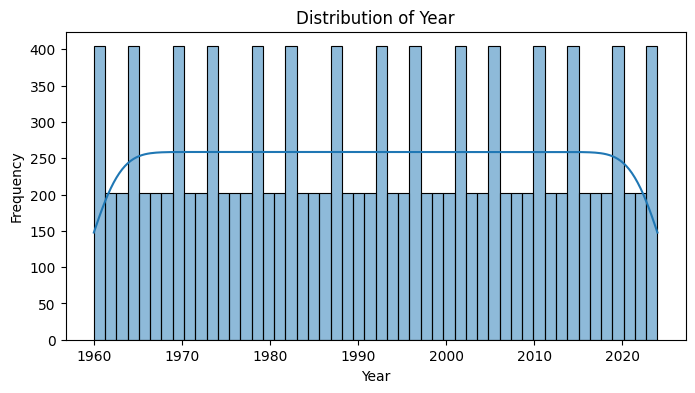

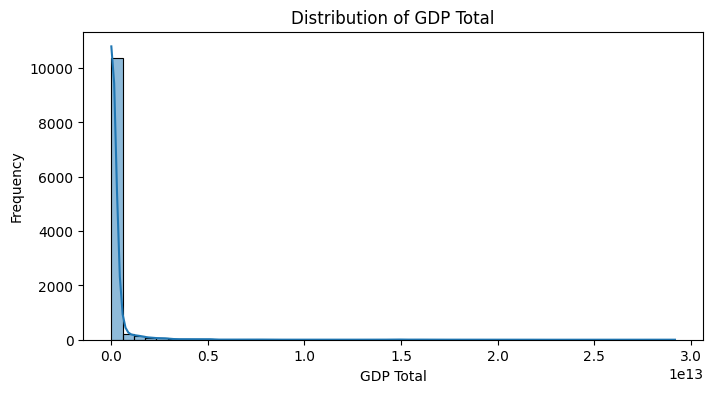

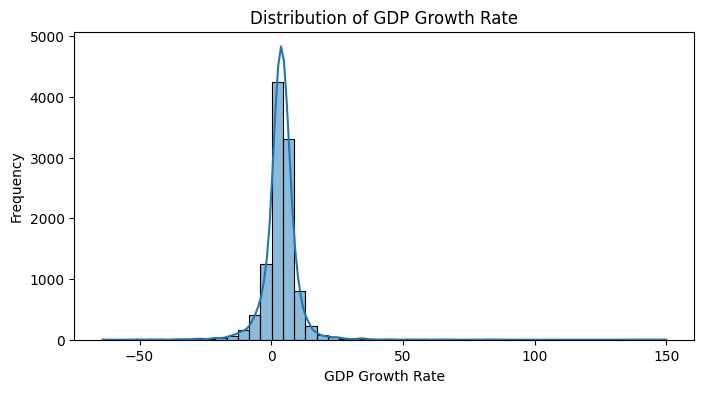

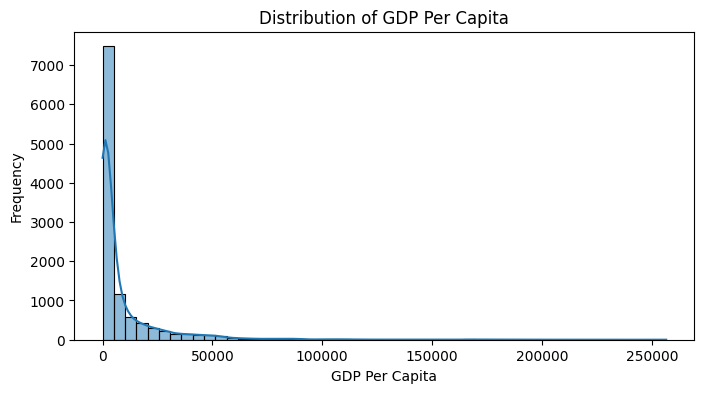

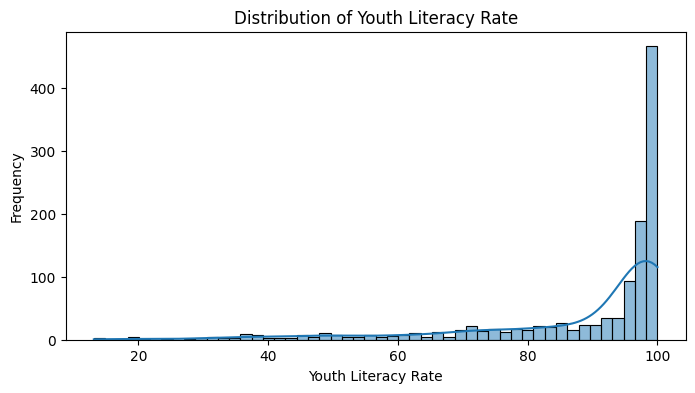

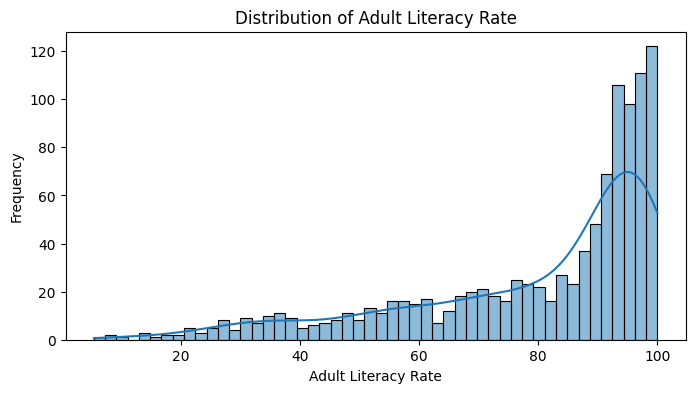

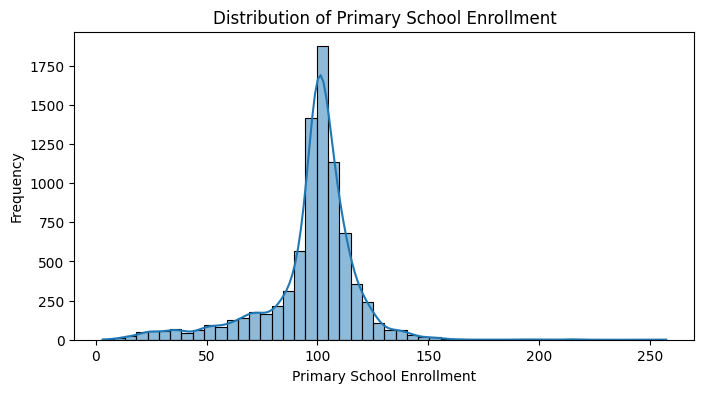

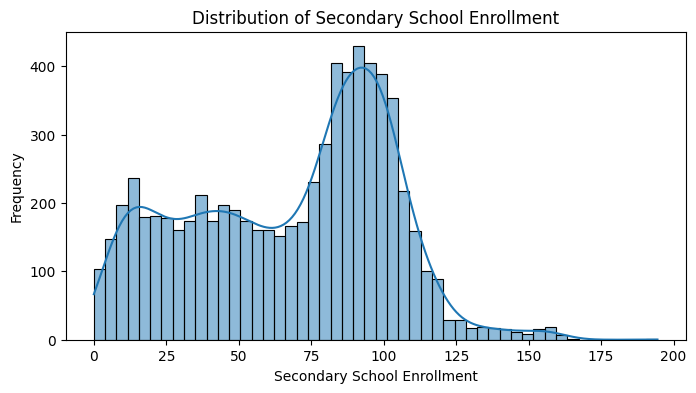

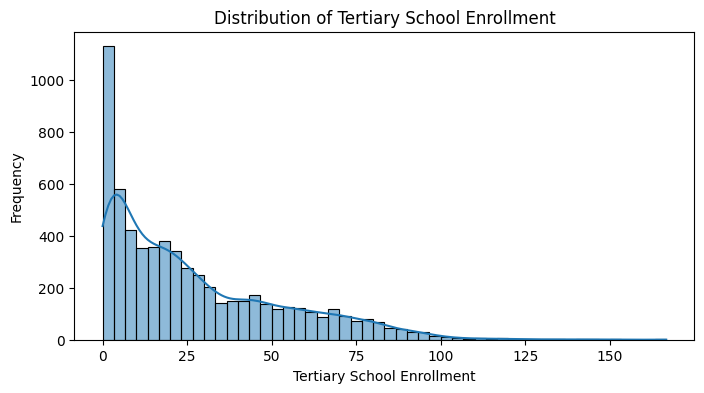

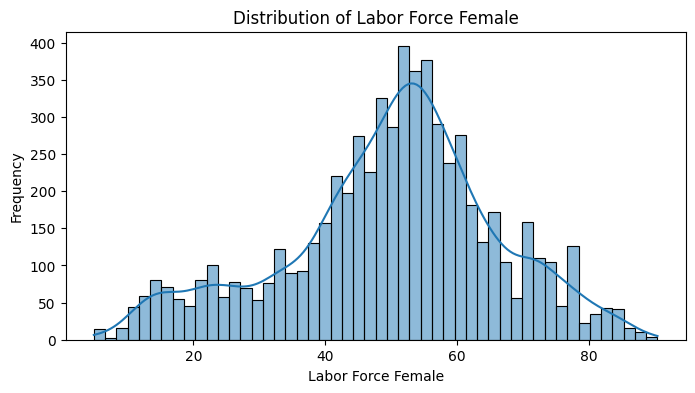

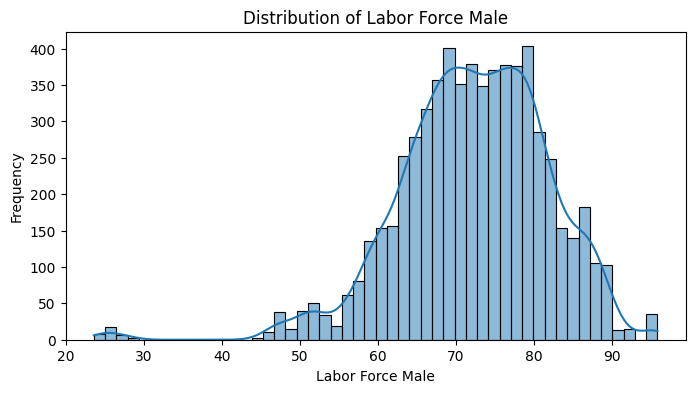

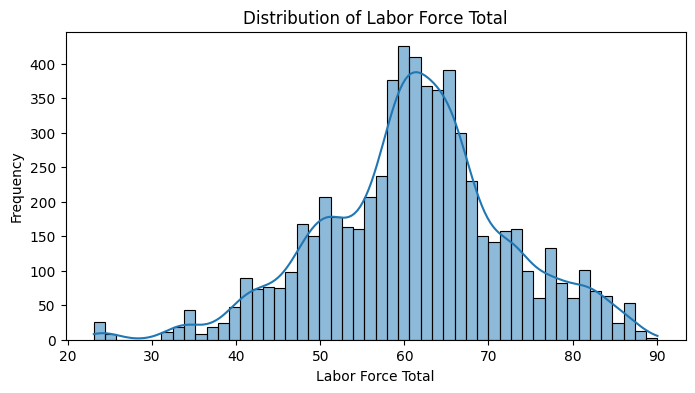

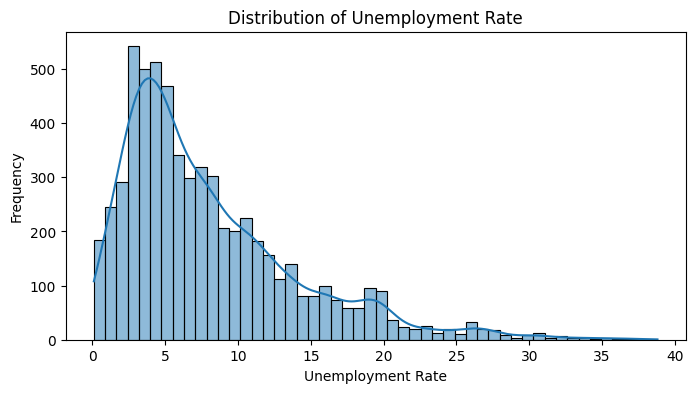

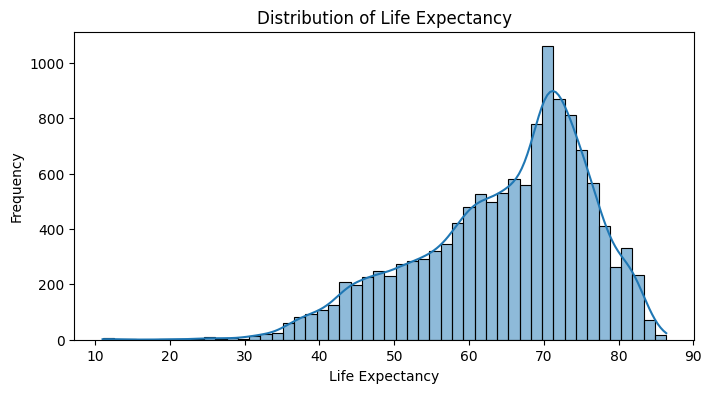

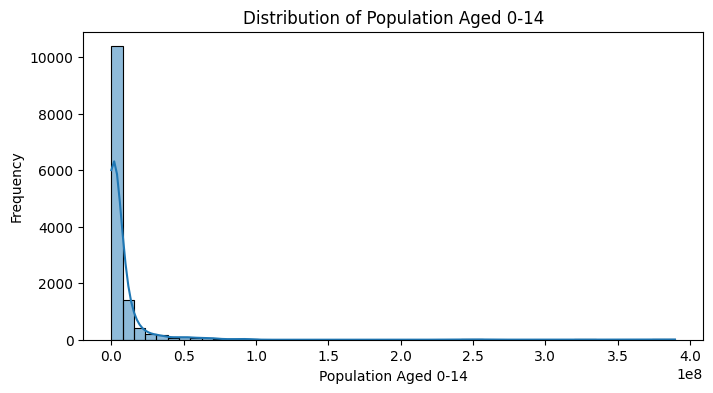

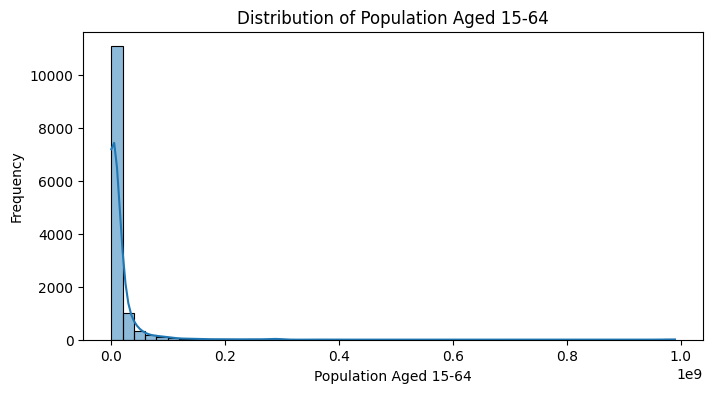

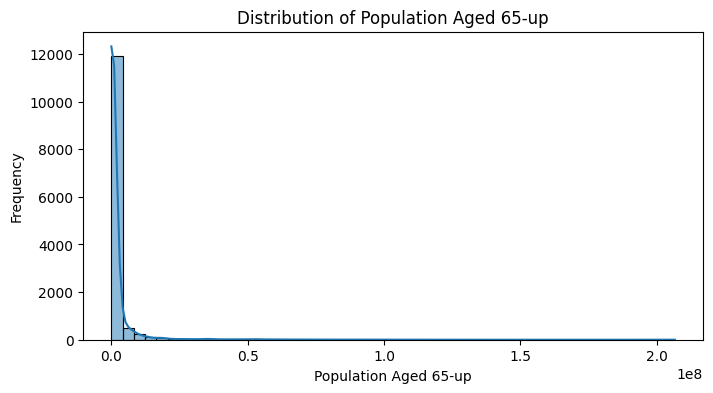

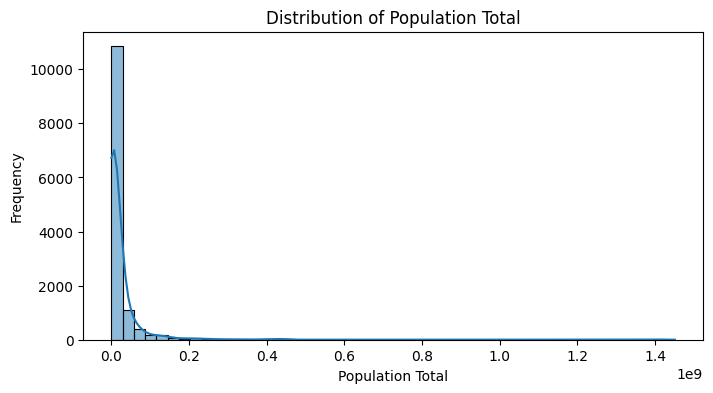

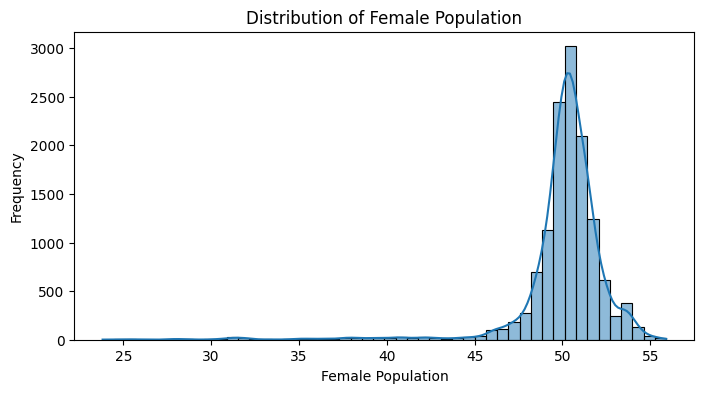

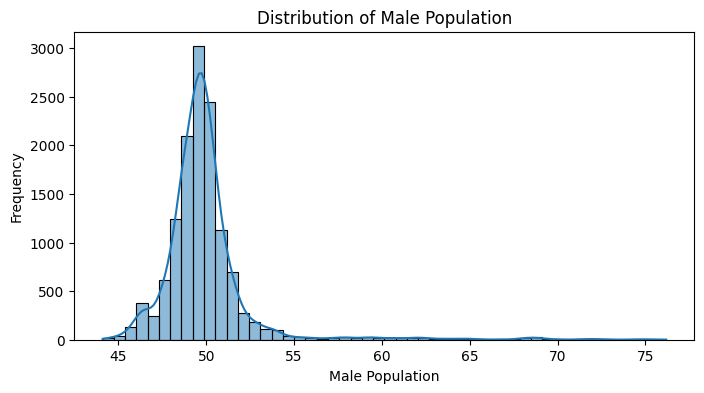

In [10]:
# Plot feature distributions for all numeric features
features = [col for col in numeric_cols]
for feature in features:
    plt.figure(figsize=(8,4))
    sns.histplot(df[feature], kde=True, bins=50)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


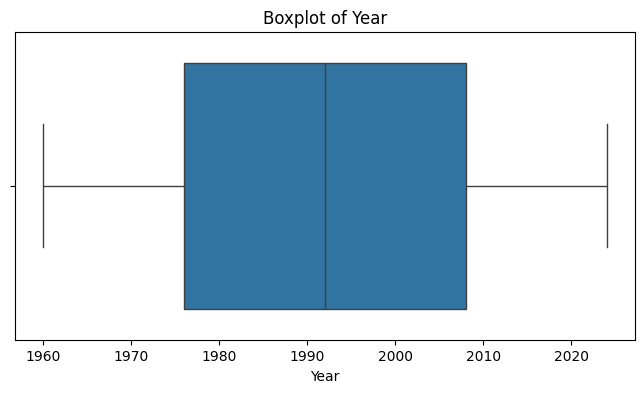

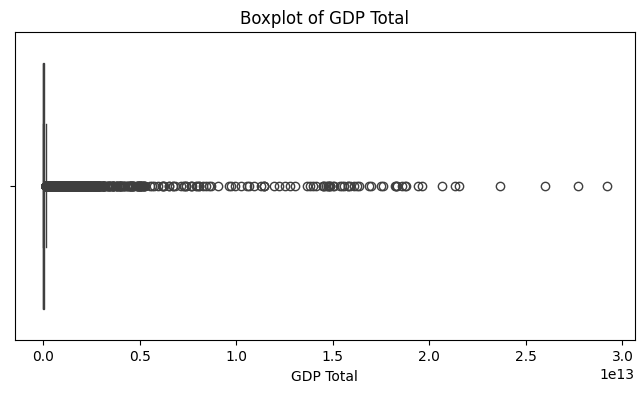

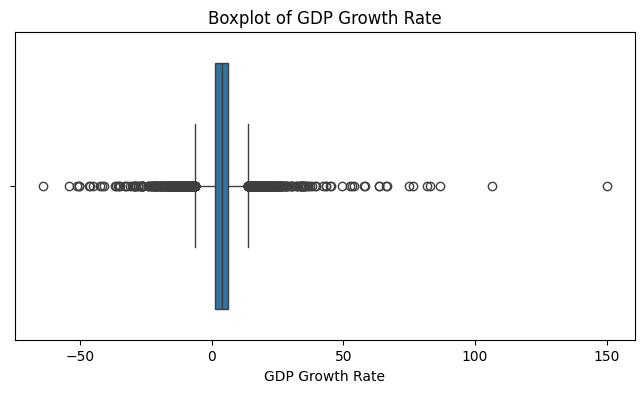

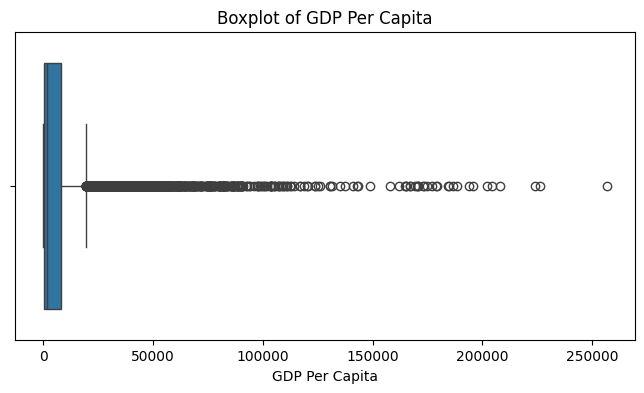

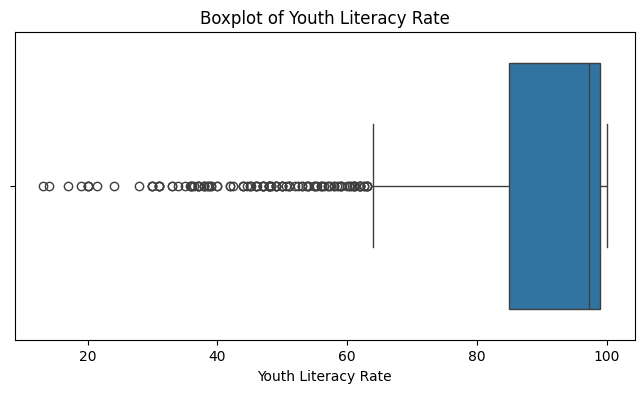

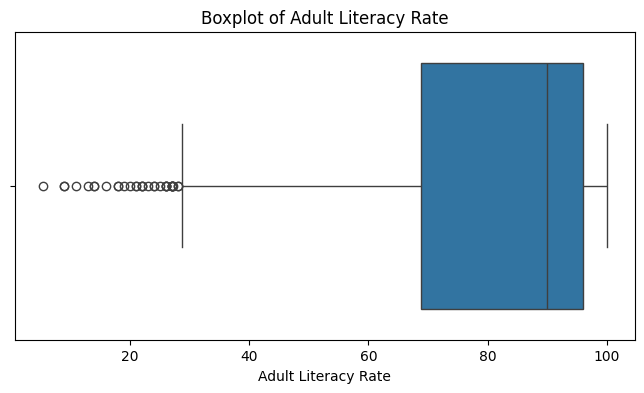

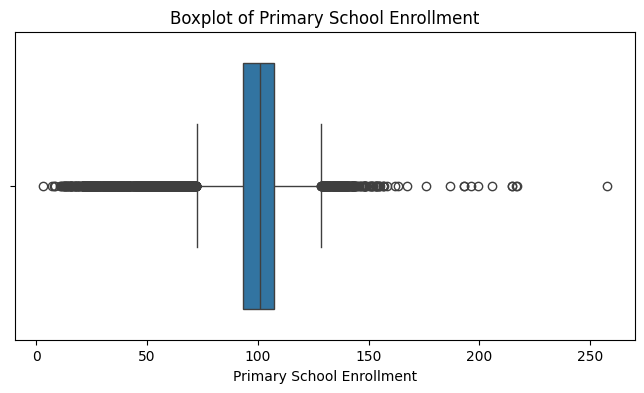

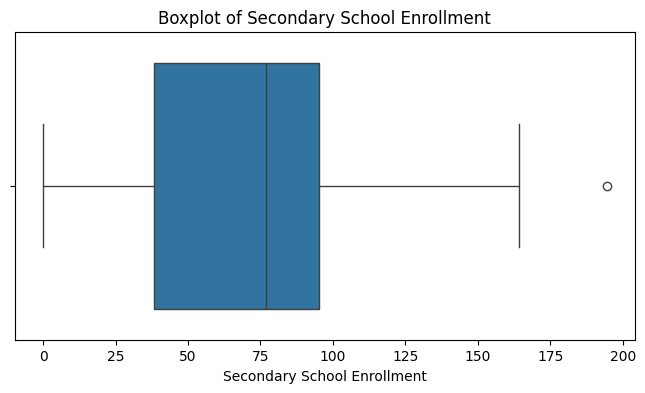

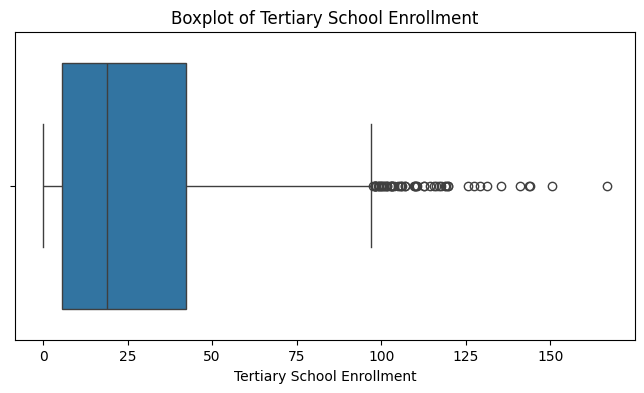

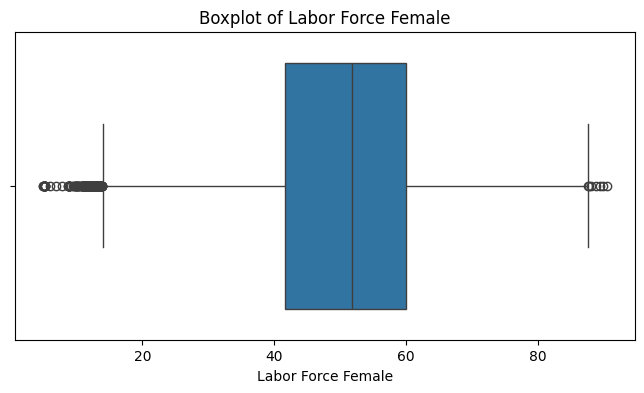

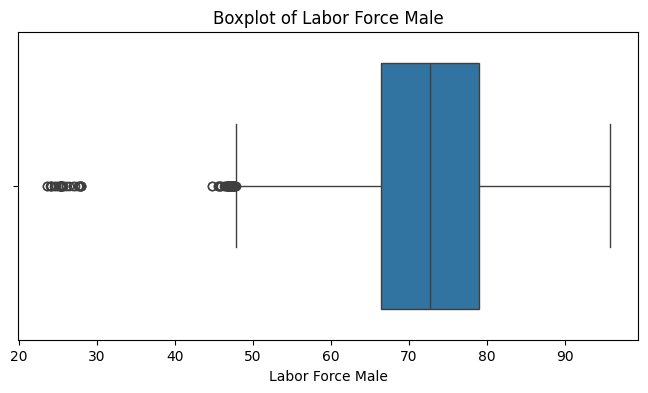

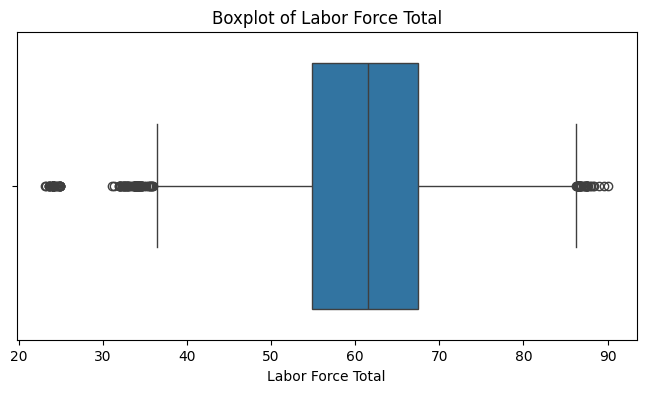

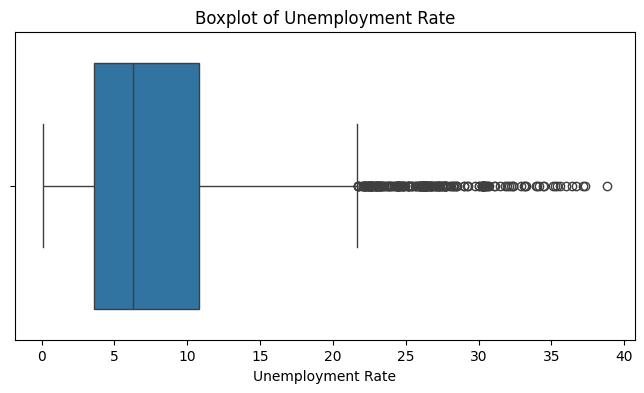

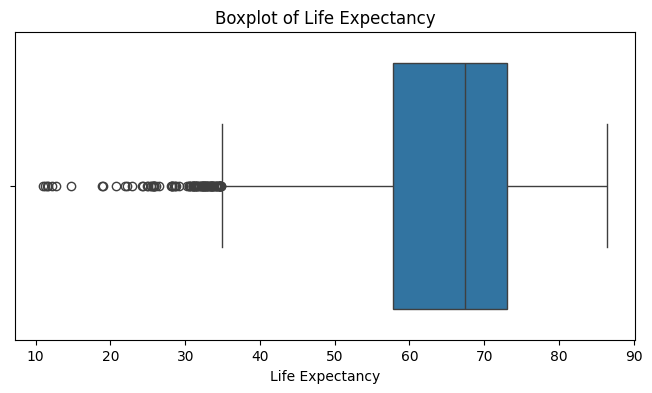

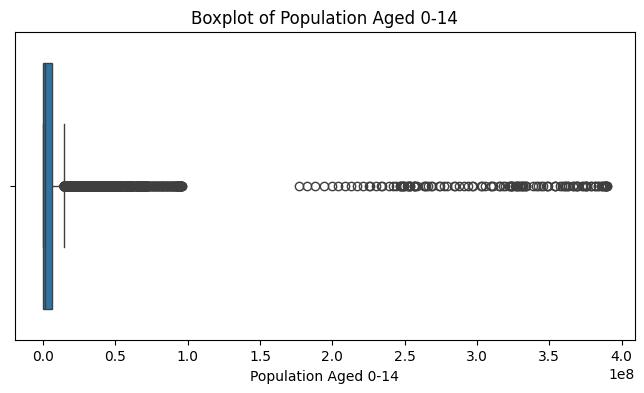

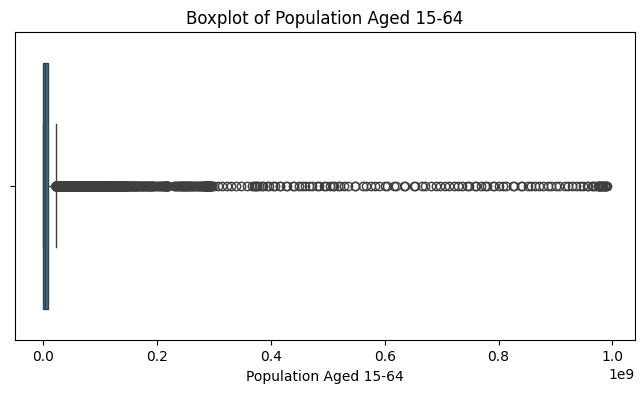

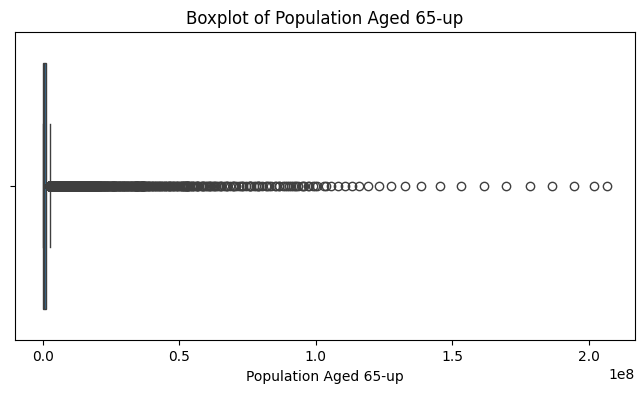

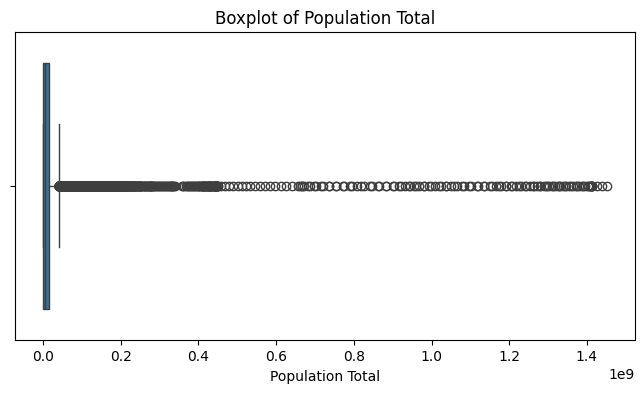

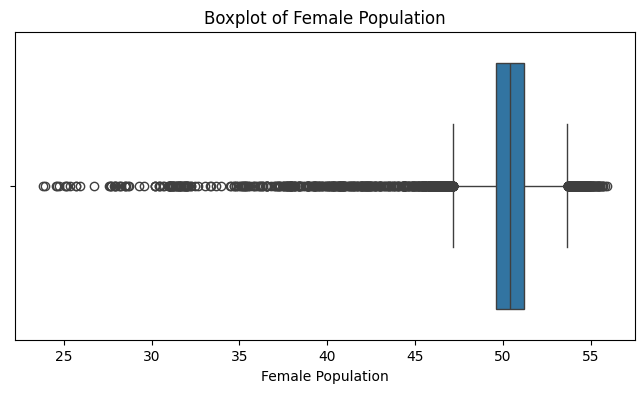

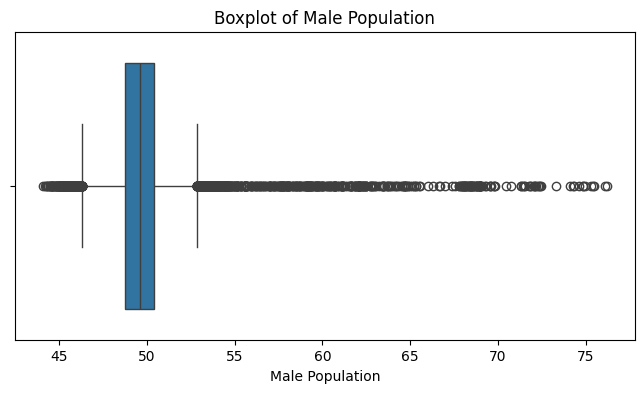

In [11]:
# Detect outliers (boxplots) for all numeric columns
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

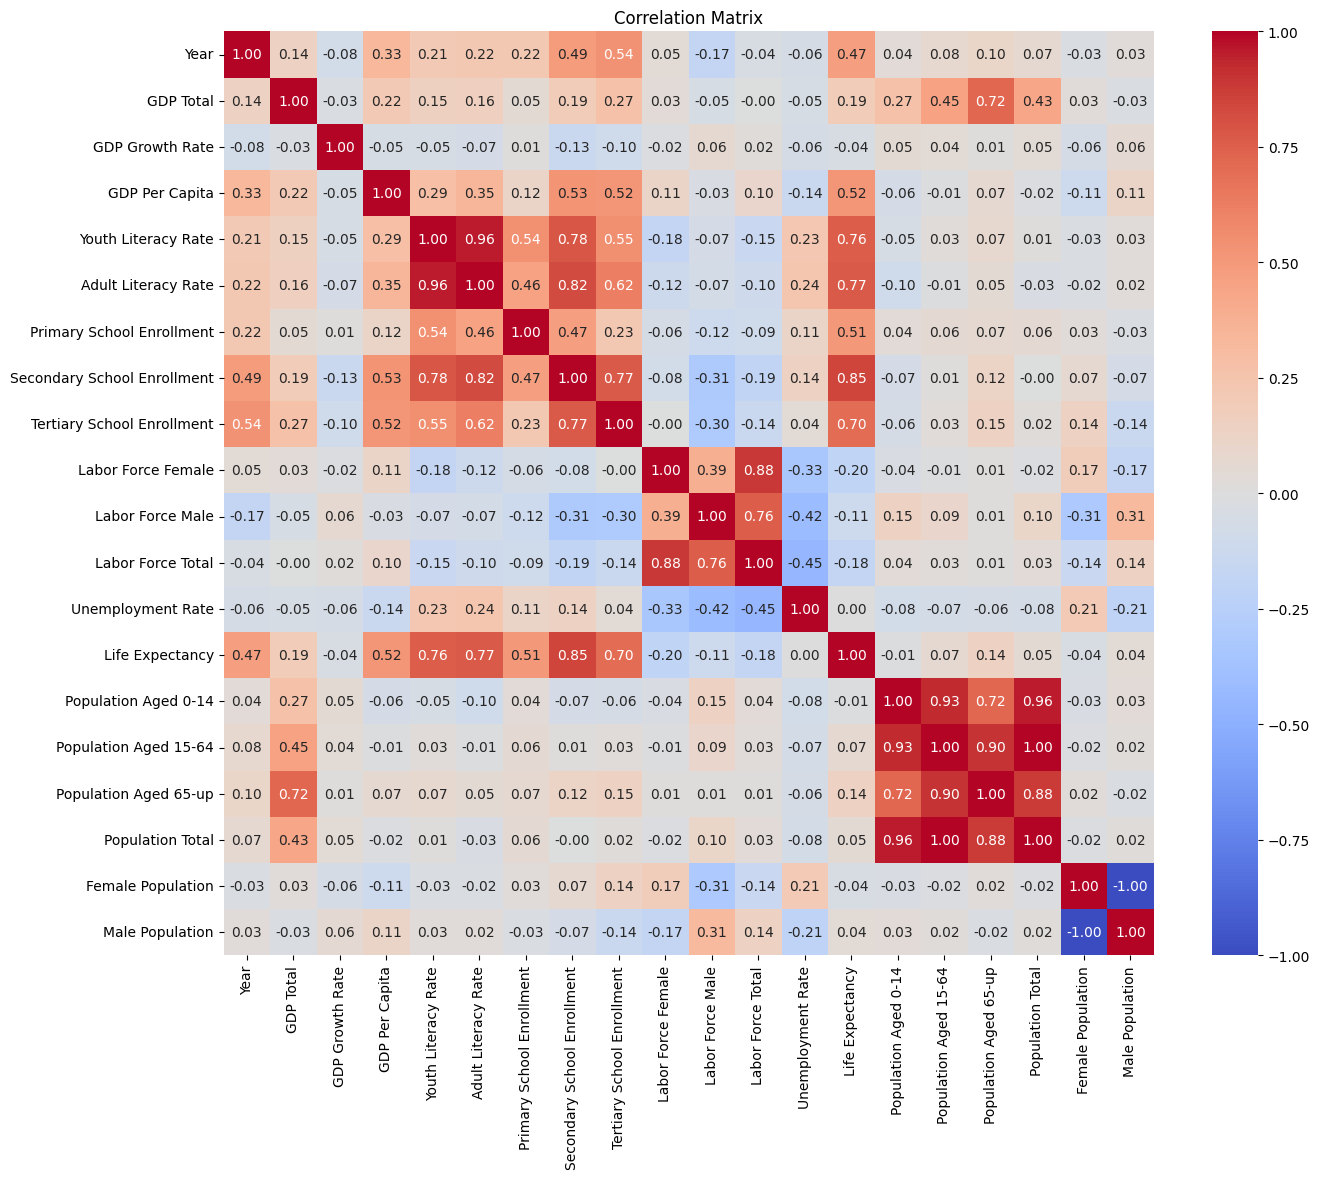

In [12]:
# Compute and visualize correlation matrix for numeric columns
plt.figure(figsize=(15,12))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Data Preparation.

In [13]:
df_clean = df.copy()

In [14]:
# Remove non-useful categorical columns

drop_cat_cols = [
    'ISO2 Code',                  # redundant with Country
    'Coordinates',                # irregular strings, hard to use,
    'Membership',                 # categorical with many levels, not useful for regression
]

df_clean = df_clean.drop(columns=drop_cat_cols)
print("Dropped columns:", drop_cat_cols)


Dropped columns: ['ISO2 Code', 'Coordinates', 'Membership']


In [15]:
# Check missing value percentages
missing_percent = df_clean.isnull().mean() * 100
missing_percent.sort_values(ascending=False)


Adult Literacy Rate            91.964966
Youth Literacy Rate            90.822544
Unemployment Rate              53.198781
Tertiary School Enrollment     52.505712
Labor Force Total              51.820259
Labor Force Male               51.820259
Labor Force Female             51.820259
Secondary School Enrollment    46.991622
Primary School Enrollment      37.143945
GDP Growth Rate                18.194973
GDP Total                      15.704494
GDP Per Capita                 15.658797
Life Expectancy                 1.797411
Population Aged 0-14            0.228484
Population Aged 65-up           0.228484
Population Total                0.228484
Population Aged 15-64           0.228484
Year                            0.000000
Country                         0.000000
Regional Group                  0.000000
Female Population               0.000000
Male Population                 0.000000
dtype: float64

In [16]:
# Classify columns by missing rate
# Thresholds: low <5%, moderate 5-60%, high >60%
low_missing_cols = missing_percent[missing_percent < 5].index.tolist()
moderate_missing_cols = missing_percent[(missing_percent >= 5) & (missing_percent <= 60)].index.tolist()
high_missing_cols = missing_percent[missing_percent > 60].index.tolist()

print("\nLow missing (<5%) columns:", low_missing_cols)
print("Moderate missing (5-50%) columns:", moderate_missing_cols)
print("High missing (>50%) columns:", high_missing_cols)


Low missing (<5%) columns: ['Year', 'Regional Group', 'Country', 'Life Expectancy', 'Population Aged 0-14', 'Population Aged 15-64', 'Population Aged 65-up', 'Population Total', 'Female Population', 'Male Population']
Moderate missing (5-50%) columns: ['GDP Total', 'GDP Growth Rate', 'GDP Per Capita', 'Primary School Enrollment', 'Secondary School Enrollment', 'Tertiary School Enrollment', 'Labor Force Female', 'Labor Force Male', 'Labor Force Total', 'Unemployment Rate']
High missing (>50%) columns: ['Youth Literacy Rate', 'Adult Literacy Rate']


In [17]:
# Decide targets based on low missing values (less than ~5%) and business relevance
low_missing_targets = missing_percent[(missing_percent > 0) & (missing_percent <= 5)].index.tolist()
print("All moderate-missing columns:", low_missing_targets)

# Choose first 3 columns as main targets
target = low_missing_targets[:1]
print("Selected main target for regression:", target)

All moderate-missing columns: ['Life Expectancy', 'Population Aged 0-14', 'Population Aged 15-64', 'Population Aged 65-up', 'Population Total']
Selected main target for regression: ['Life Expectancy']


In [18]:
# Remove extremely high-missing columns

drop_hm_cols = [
    'Adult Literacy Rate',       # ~92% missing
    'Youth Literacy Rate',       # ~91% missing
]

df_clean = df_clean.drop(columns=drop_hm_cols)
print("Dropped columns:", drop_hm_cols)


Dropped columns: ['Adult Literacy Rate', 'Youth Literacy Rate']


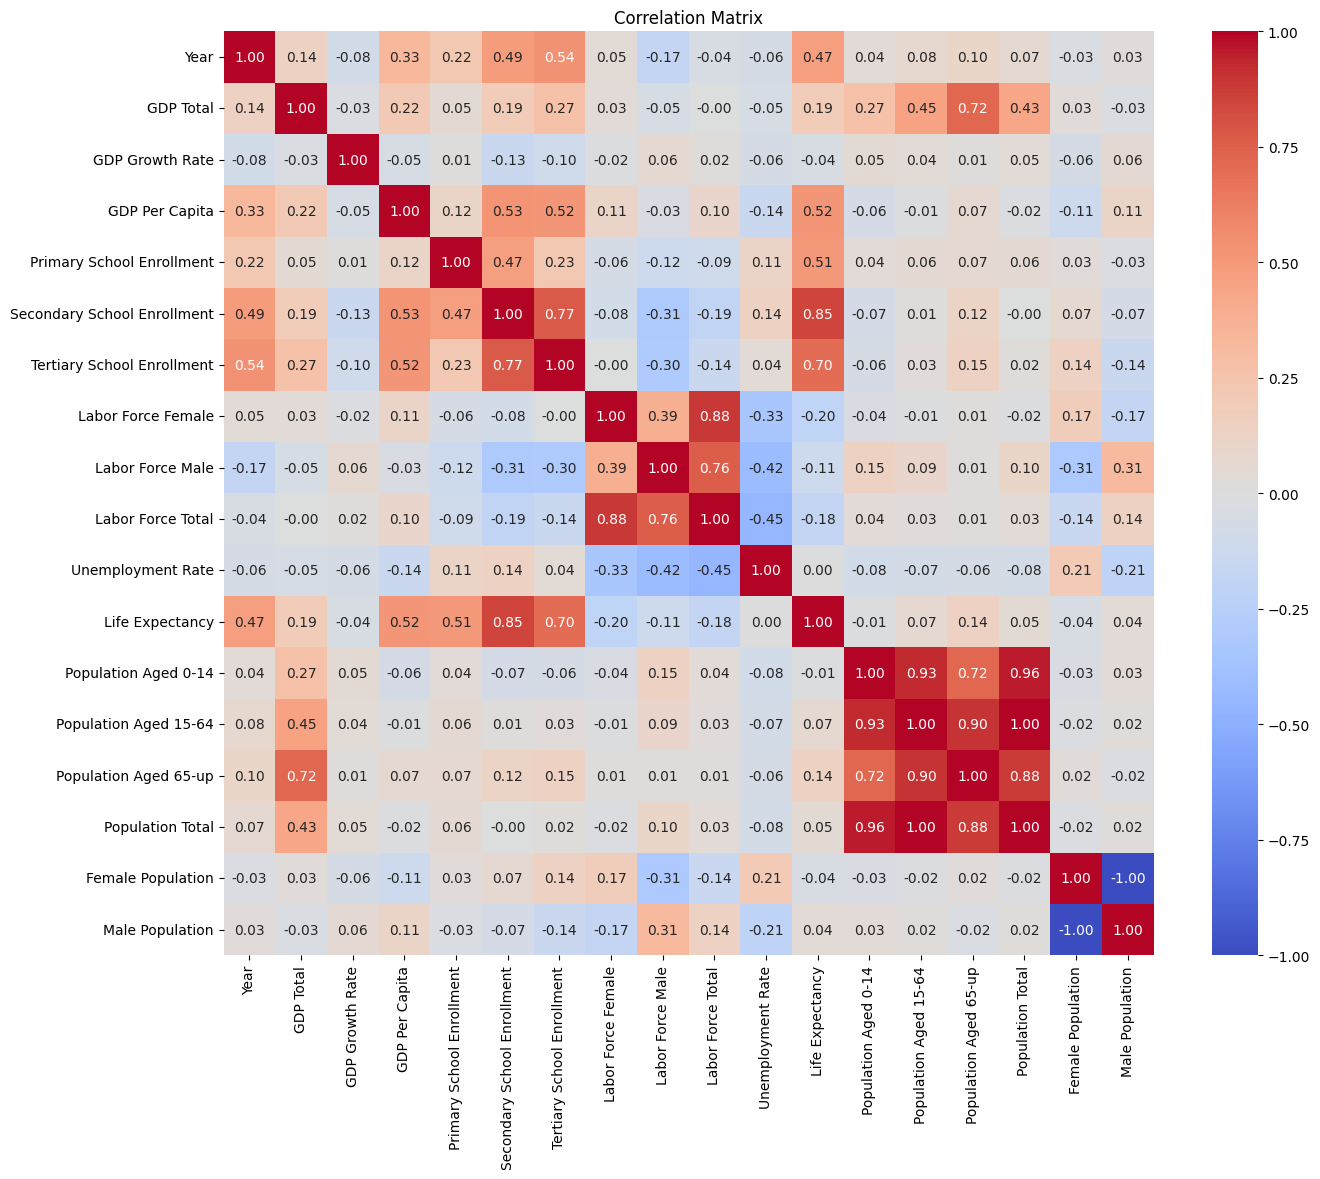

In [19]:
# Numeric columns
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Compute and visualize correlation matrix for numeric columns
plt.figure(figsize=(15,12))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [20]:
# Remove highly not-correlated columns to the target

drop_cols = [
    'GDP Growth Rate',
    'Labor Force Female',
    'Labor Force Male',
    'Labor Force Total',
    'Unemployment Rate',
    'Population Aged 0-14',
    'Population Aged 15-64',
    'Population Aged 65-up',
    'Female Population',
    'Male Population',
    'Population Total',
]

df_clean = df_clean.drop(columns=drop_cols)
print("Dropped columns:", drop_cols)


Dropped columns: ['GDP Growth Rate', 'Labor Force Female', 'Labor Force Male', 'Labor Force Total', 'Unemployment Rate', 'Population Aged 0-14', 'Population Aged 15-64', 'Population Aged 65-up', 'Female Population', 'Male Population', 'Population Total']


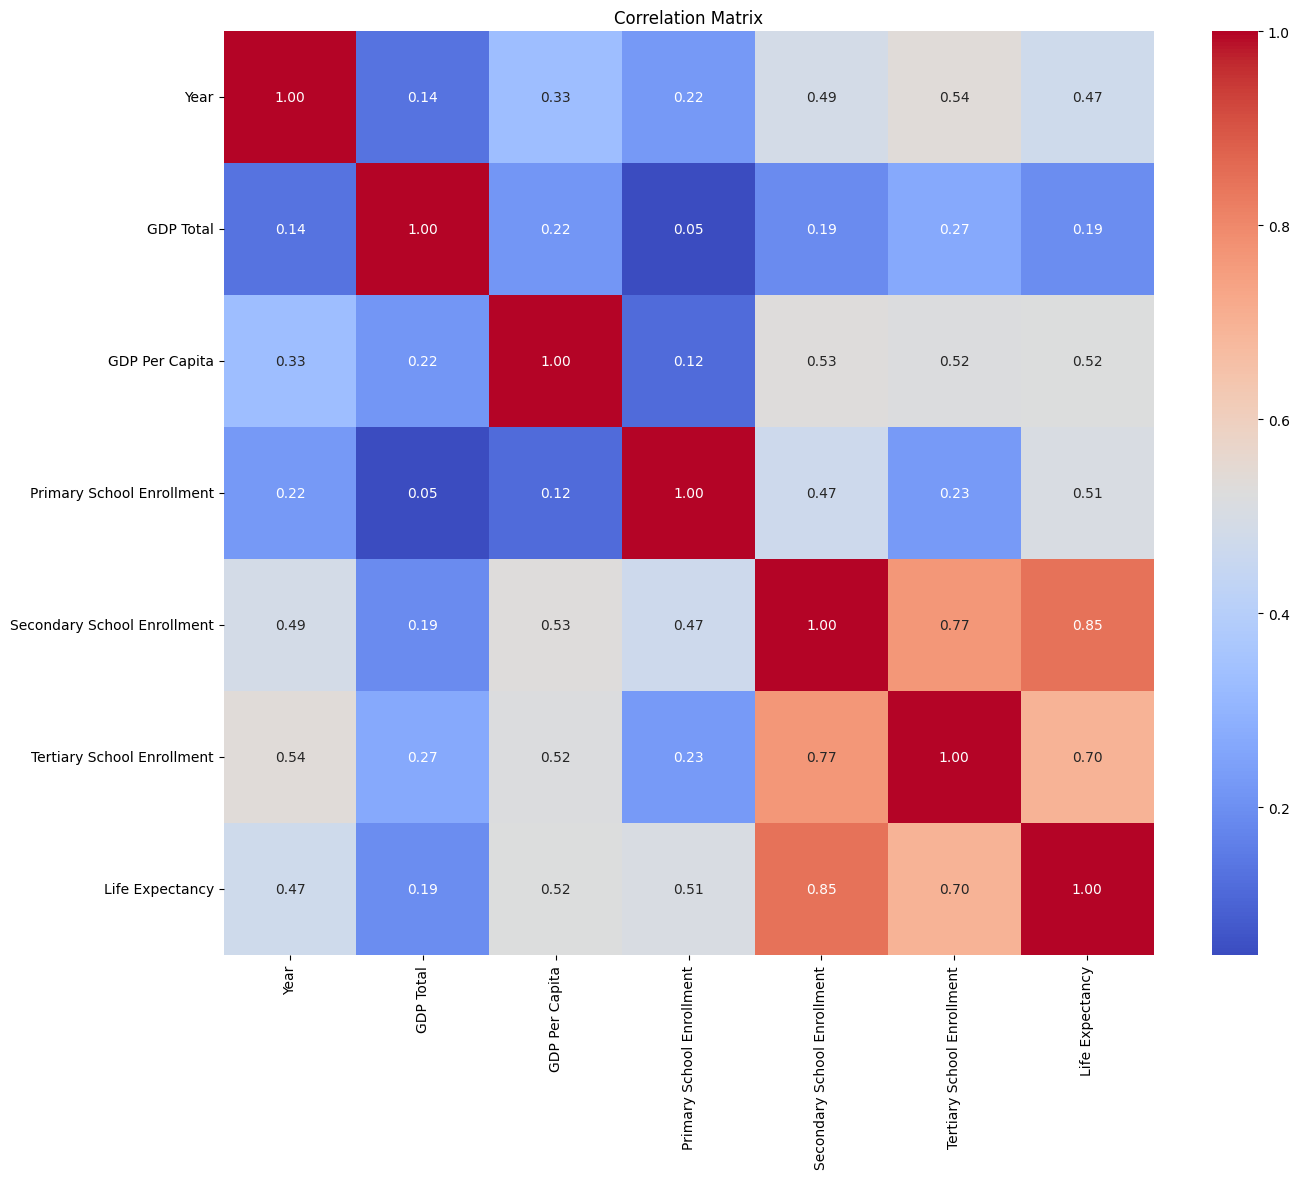

In [21]:
# Numeric columns
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Compute and visualize correlation matrix for numeric columns
plt.figure(figsize=(15,12))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [22]:
# Fill missing values using median per country
for col in numeric_cols:
    df_clean[col] = df_clean.groupby('Country')[col].transform(
        lambda x: x.fillna(x.median())
    )

# Fallback global median (rare cases)
for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())


c:\Users\ENVY\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\ENVY\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\ENVY\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\ENVY\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\ENVY\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keep

In [23]:
# Step 1: Select numeric columns
numeric_df = df_clean.select_dtypes(include=['float64', 'int64'])

# Step 2: Compute correlation matrix
corr_matrix = numeric_df.corr().abs()

# Step 3: Compute mean correlation for each possible target
mean_corr = corr_matrix.mean().sort_values(ascending=False)

# Display ranked list
print("Mean absolute correlation of each variable:\n")
print(mean_corr)

# Optional: pick top 5 best targets
top_targets = mean_corr.index[:5]
print("\nTop 5 most correlated (most predictable) potential targets:\n", top_targets)


Mean absolute correlation of each variable:

Life Expectancy                0.556511
Secondary School Enrollment    0.509619
Tertiary School Enrollment     0.479160
GDP Per Capita                 0.429764
Primary School Enrollment      0.340134
Year                           0.332894
GDP Total                      0.275490
dtype: float64

Top 5 most correlated (most predictable) potential targets:
 Index(['Life Expectancy', 'Secondary School Enrollment',
       'Tertiary School Enrollment', 'GDP Per Capita',
       'Primary School Enrollment'],
      dtype='object')


In [24]:
# One-hot encode Country + Regional Group
df_model = pd.get_dummies(df_clean, columns=['Country', 'Regional Group'], drop_first=True)

In [25]:
# Separate features & target
X = df_model.drop(columns=target)
y = df_model[target]

In [26]:
# Feature scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes:
X_train: (10504, 214)
X_test: (2626, 214)
y_train: (10504, 1)
y_test: (2626, 1)


# Model training

In [28]:
# MODEL 1 — LINEAR REGRESSION

# Target variable
y_train_lr = y_train[target]
y_test_lr = y_test[target]

# Base model
lr = LinearRegression()

# Updated param grid (normalize removed)
param_grid_lr = {
    "fit_intercept": [True, False],
    "positive": [False, True]
}

grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

# Train
grid_lr.fit(X_train, y_train_lr)

best_lr = grid_lr.best_estimator_

print("Best Linear Regression Params:", grid_lr.best_params_)


Best Linear Regression Params: {'fit_intercept': True, 'positive': False}


In [29]:
# MODEL 2 — RANDOM FOREST REGRESSOR

# Target variable
y_train_rf = y_train[target]

# Base model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter search grid
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

# Grid Search
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

# Train model
grid_rf.fit(X_train, y_train_rf)

# Best model
best_rf = grid_rf.best_estimator_

print("Best Random Forest Params:", grid_rf.best_params_)


c:\Users\ENVY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [30]:
df_clean.shape

(13130, 9)

In [31]:
# MODEL 3 — GRADIENT BOOSTING REGRESSOR (GDP Growth Rate)

# Target variable
y_train_gb = y_train[target]

# Base model
gb = GradientBoostingRegressor(random_state=42)

# Hyperparameter tuning grid
param_grid_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# Grid Search
grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

# Train tuning process
grid_gb.fit(X_train, y_train_gb)

# Best model
best_gb = grid_gb.best_estimator_

print("Best Gradient Boosting Params:", grid_gb.best_params_)


c:\Users\ENVY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Best Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}


In [32]:
import joblib

joblib.dump(best_rf, "models/best_random_forest.pkl")
joblib.dump(best_gb, "models/best_gb.pkl")
joblib.dump(best_lr, "models/best_lr.pkl")


['models/best_lr.pkl']

# Model evaluation

In [ ]:
# Function to evaluate a single model
def evaluate(model, X_test, y_test, label):
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    return {
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2
    }

# Evaluate each model
results = []
results.append(evaluate(best_lr, X_test, y_test[target], "Linear Regression"))
results.append(evaluate(best_rf, X_test, y_test[target], "Random Forest"))
results.append(evaluate(best_gb, X_test, y_test[target], "Gradient Boosting"))

# Convert to DataFrame
results_df = pd.DataFrame(results)

print("Evaluation Results for GDP Growth Rate:")
results_df


Evaluation Results for GDP Growth Rate:


,Model,MAE,RMSE,R2 Score
0,Linear Regression,2.437971,3.597574,0.898653
1,Random Forest,0.917599,1.840049,0.973487
2,Gradient Boosting,2.085484,2.888393,0.934671


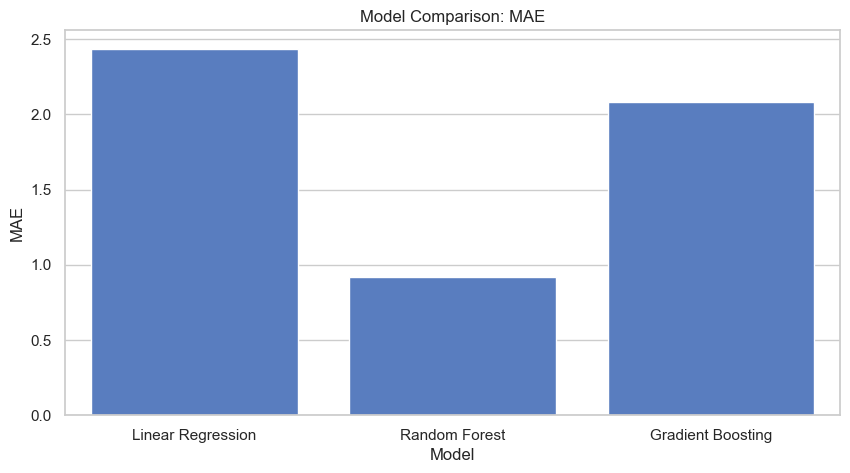

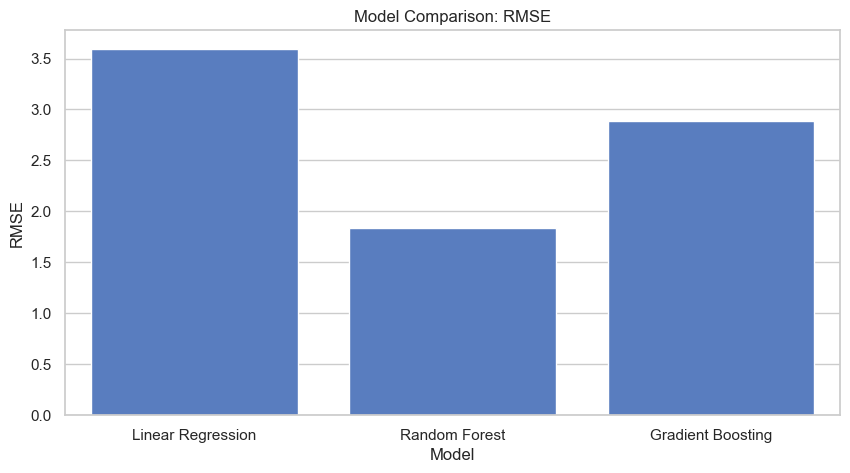

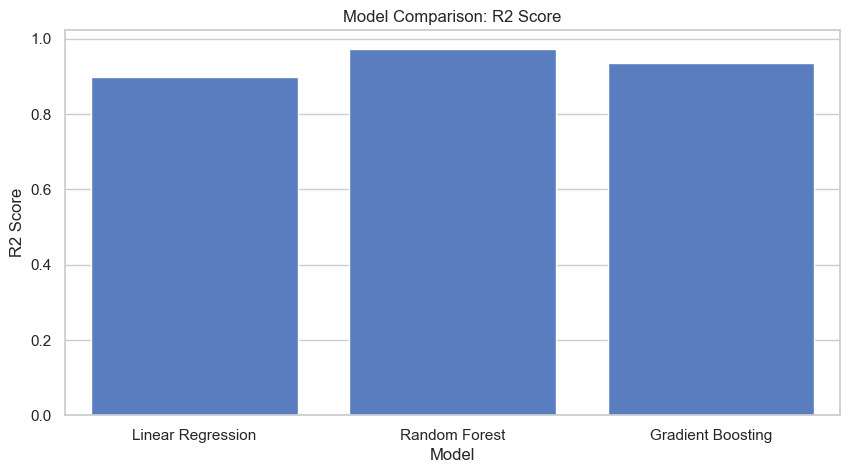

In [ ]:
# Comparison bar charts (MAE/RMSE/R²)
plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="Model", y="MAE")
plt.title("Model Comparison: MAE")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="Model", y="RMSE")
plt.title("Model Comparison: RMSE")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="Model", y="R2 Score")
plt.title("Model Comparison: R2 Score")
plt.show()


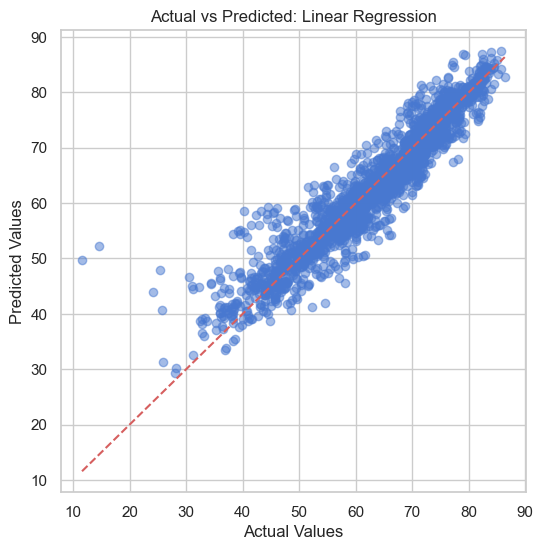

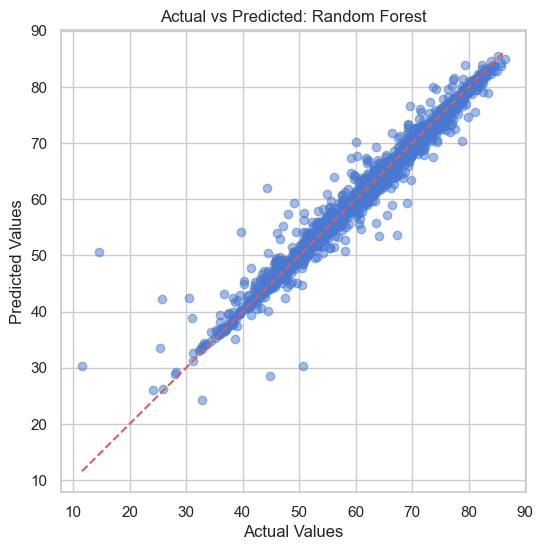

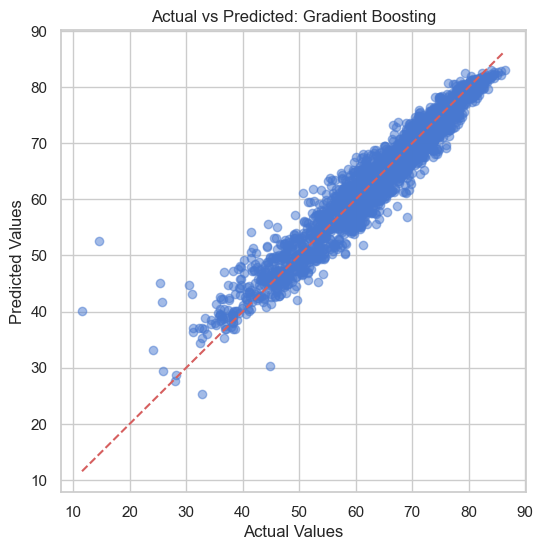

In [216]:
# Models and their labels
best_models = [
    ("Linear Regression", best_lr),
    ("Random Forest", best_rf),
    ("Gradient Boosting", best_gb)
]

# Prediction vs Actual plot for the BEST models
for model_name, model in best_models:
    preds = model.predict(X_test)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted: {model_name}")
    plt.show()


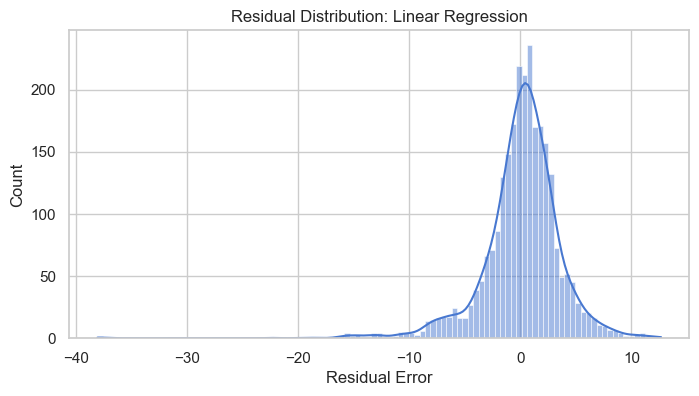

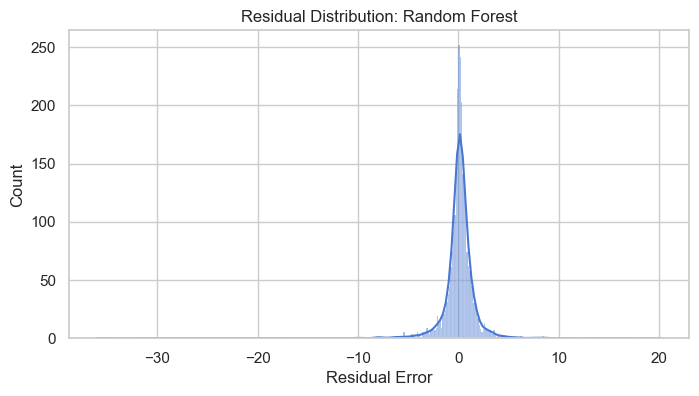

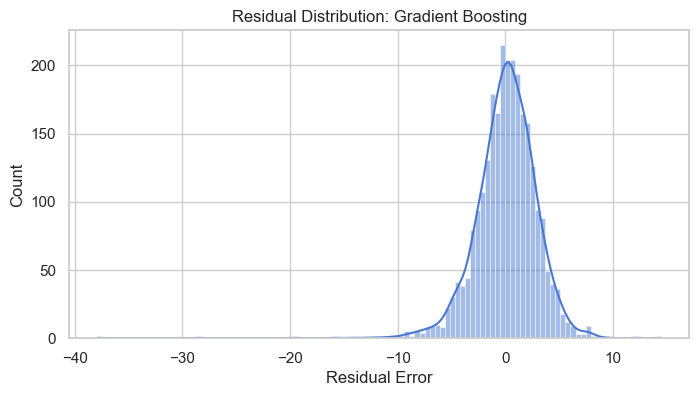

In [218]:
# Models and their labels
best_models = [
    ("Linear Regression", best_lr),
    ("Random Forest", best_rf),
    ("Gradient Boosting", best_gb),
]

for model_name, model in best_models:
    preds = model.predict(X_test).ravel()
    y_test_series = y_test.squeeze().ravel()
    residuals = y_test_series - preds

    plt.figure(figsize=(8,4))
    sns.histplot(residuals, kde=True)
    plt.title(f"Residual Distribution: {model_name}")
    plt.xlabel("Residual Error")
    plt.show()
